tgb - 11/12/2019 - Phase 1 of the project - Changing the inputs without changing the outputs

# 0) Initialization

Import utilities

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog


W1112 18:34:04.666904 22507181705024 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:145: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1112 18:34:04.667616 22507181705024 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

W1112 18:34:04.669150 22507181705024 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# 1) Develop utilities to recast inputs

We would like to rephrase two types of inputs:  
1) Temperature as a deviation from the moist adiabat to avoid going out of training  
2) Moisture variables, including microphysical variables, as relative humidities to avoid going out of training  
3) Fow now, we will ignore "large-scale tendencies"   
We will then train networks with similar architectures, one with "rephrased" inputs and one without to see if the one with "rephrased" inputs generalizes better to +4K near the Equator

In [2]:
data = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)

In [3]:
data

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 48)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon           (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 ... 38.27 24.61 14.36
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * time          (time) float64 0.0 0.02083 0.04167 ... 0.9375 0.9583 0.9792
Dimensio

## 1.1) Code up relative humidity from Tristan's utilities

From [https://github.com/thabbott/matlab]. Since the microphysics scheme is one-moment, we only need to keep track of a single relative humidity that takes into account both the saturation pressure with respect to liquid and ice.

In [67]:
# SAM Constants, TODO = Check that they are the same in SPCAM
# In functions
a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
c_liq = -80
c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
# General
R = 287
Rv = 461
T0 = 273.16
T00 = 253.16

In [20]:
# Test variables
T = data.T # Absolute temperature (K)
# From temperature, get saturation pressure over liquid
Xliq = np.maximum(c_liq,T-T0)
eliq = 100*np.polyval(a_liq,Xliq)

In [34]:
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

In [128]:
# Test variables
T = data.T.values # Absolute temperature (K)
# From temperature, set saturation pressure over ice
eice = (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

In [129]:
def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

In [122]:
def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))
    
    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

In [136]:
# Test variables
p = np.moveaxis((data.hyam*data.P0+data.hybm*data.PS).values,0,1) # Total pressure (Pa)
T = data.T # Absolute temperature (K)
qv = data.QAP # Specific humidity (kg/kg)
ql = data.QCAP # Liquid water (kg/kg)
qi = data.QIAP # Ice (kg/kg)
# From specific humidity, liquid water and ice to relative humidity
# 1) Partial pressure from total water and temperature
e = Rv*p*qv/R
# 2) Relative humidity from saturation pressure
RH = e/esat(T)
# 3) Relative humidity from saturation specific humidity
qsatl=R/Rv*eliq(T)/np.maximum(eliq(T),p-eliq(T))
RHliq = qv/qsatl
qsati=R/Rv*eice(T)/np.maximum(eice(T),p-eice(T))
RHice = qv/qsati

In [156]:
def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = np.moveaxis((hyam*P0+hybm*PS).values,0,1) # Total pressure (Pa)
    return Rv*p*qv/(R*esat(T))

In [158]:
RH0 = RH(data.T,data.QAP,data.P0,data.PS,data.hyam,data.hybm)

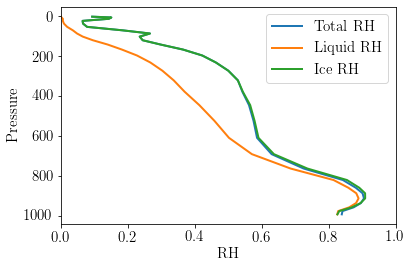

In [165]:
# Plot characteristics
fz = 15
lw = 2
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

plt.plot(np.mean(RH0,axis=(0,2,3)),data.lev,label='Total RH')
plt.plot(np.mean(RHliq,axis=(0,2,3)),data.lev,label='Liquid RH')
plt.plot(np.mean(RHice,axis=(0,2,3)),data.lev,label='Ice RH')
plt.xlim((0,1))
plt.ylabel('Pressure')
plt.xlabel('RH')
plt.gca().invert_yaxis()
plt.legend()

Text(0.5, 0.98, 'Histogram of Relative humidity')

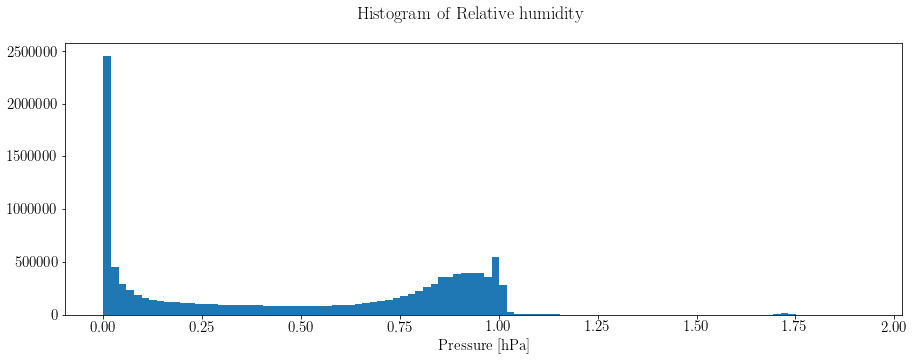

In [171]:
plt.figure(figsize=(15,5))
plt.hist(RH0.values.flatten(),bins=100)
plt.xlabel('Pressure [hPa]')
plt.suptitle("Histogram of Relative humidity")

Text(0.5, 0.98, 'Histogram of Pressure for which RH larger than1.05')

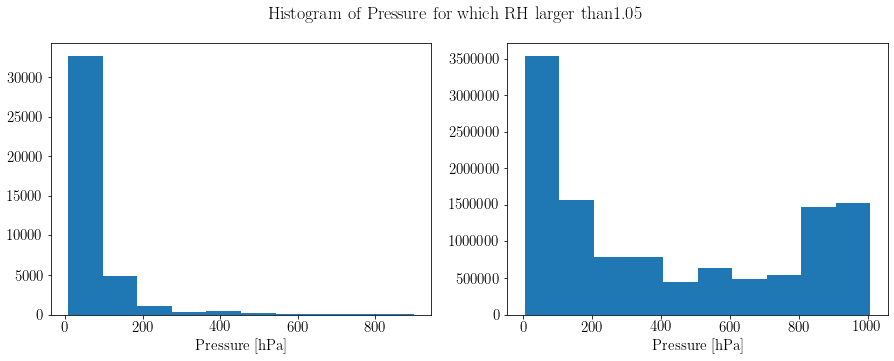

In [172]:
RHthres = 1.05
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(p[RH0>RHthres]/1e2)
plt.xlabel('Pressure [hPa]')
plt.subplot(1,2,2)
plt.hist(p.flatten()/1e2)
plt.xlabel('Pressure [hPa]')
plt.suptitle("Histogram of Pressure for which RH larger than"+str(RHthres))

## 1.2) Code up deviation from moist adiabatic profile from Tristan's utilities